# **Modelling and Evaluation**

## Objectives

* **Answer business requirement 2:**
* Client want to predicting if a cherry leaf is healthy or infected with powdery mildew.

## Inputs

* inputs/cherry-leaves/test
* inputs/cherry-leaves/train
* inputs/cherry-leaves/validation
* image shape embeddings

## Outputs

* Image distribution plot in train, validation and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* ML model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

## Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Working directory setup

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/P5CherryLeaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/P5CherryLeaves'

---

## Input directory setup

In [5]:
my_data_dir = '/workspace/P5CherryLeaves/inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Output directory setup

In [6]:
version = '4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = '4'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Explore the numbers of images in the validation, train and test datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




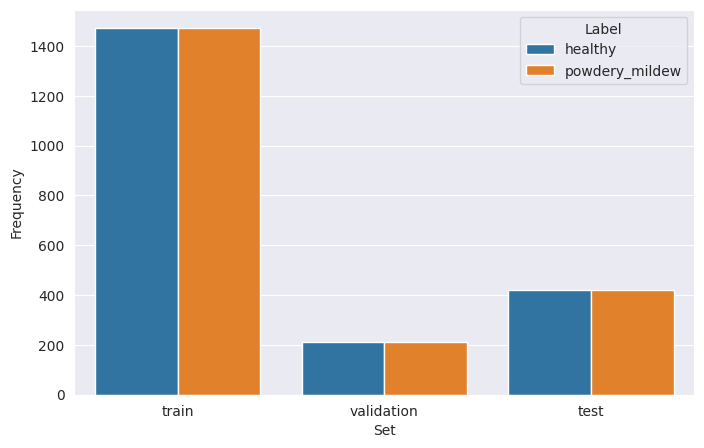

In [10]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

In [11]:
import numpy as np
np.object = object  
np.bool = bool
np.int = int

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augment training image dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented training image

(20, 256, 256, 3)


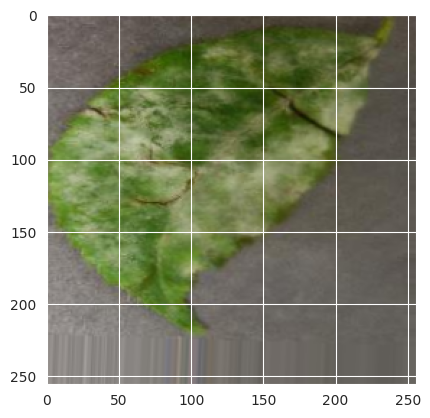

(20, 256, 256, 3)


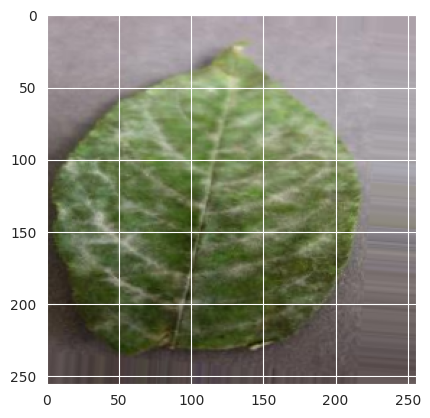

(20, 256, 256, 3)


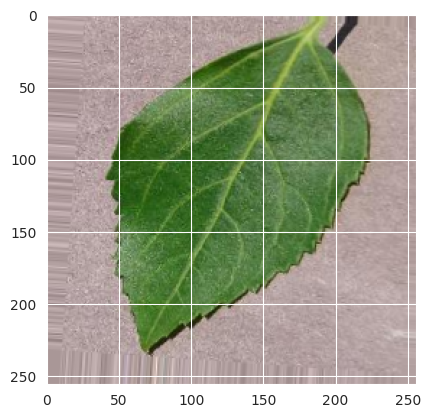

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation and test images

(20, 256, 256, 3)


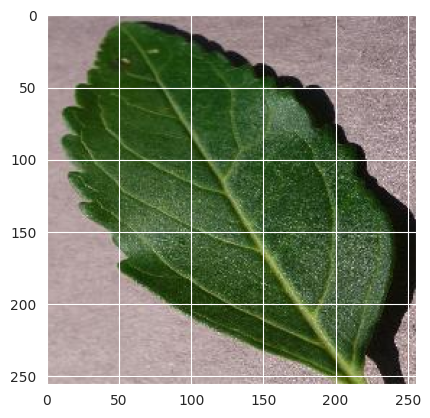

(20, 256, 256, 3)


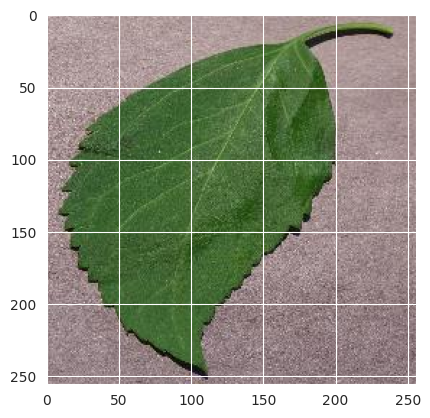

(20, 256, 256, 3)


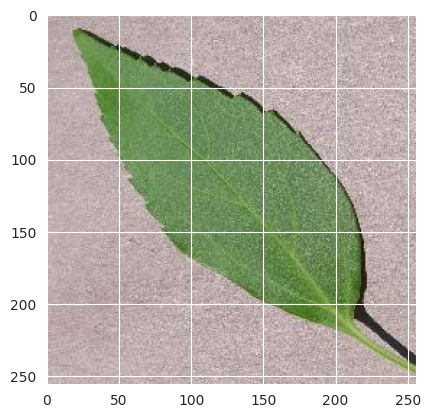

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


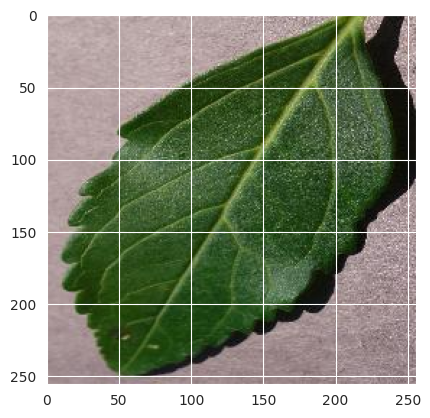

(20, 256, 256, 3)


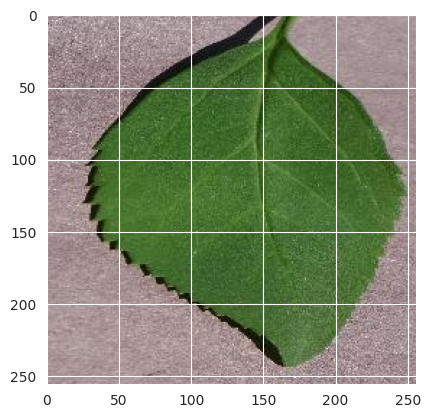

(20, 256, 256, 3)


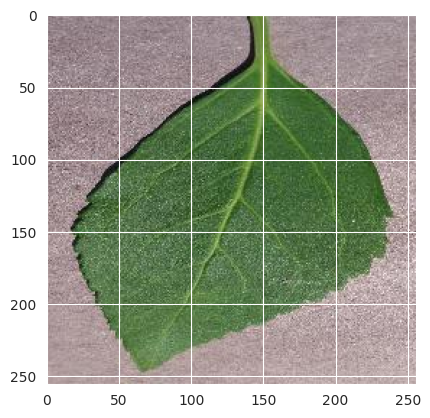

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/4/class_indices.pkl']

---

## Create ML model

---

Import packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Model

In [21]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model summary

In [22]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-03-25 23:02:45.518981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Early stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Fit model for training

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=30,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-03-25 23:03:16.668680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
147/147 [==============================] - 143s 960ms/step - loss: 0.4085 - accuracy: 0.8109 - val_loss: 0.0280 - val_accuracy: 0.9952
Epoch 2/30
147/147 [==============================] - 137s 930ms/step - loss: 0.0873 - accuracy: 0.9730 - val_loss: 0.0084 - val_accuracy: 0.9976
Epoch 3/30
147/147 [==============================] - 153s 1s/step - loss: 0.0224 - accuracy: 0.9908 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/30
147/147 [==============================] - 137s 933ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0145 - val_accuracy: 0.9976
Epoch 5/30
147/147 [==============================] - 137s 929ms/step - loss: 0.0222 - accuracy: 0.9935 - val_loss: 4.1991e-04 - val_accuracy: 1.0000
Epoch 6/30
147/147 [==============================] - 138s 937ms/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.0067 - val_accuracy: 0.9976
Epoch 7/30
147/147 [==============================] - 137s 931ms/step - loss: 0.0561 - accuracy: 0.9812 - val_loss: 9.3650e

Save model

In [25]:
model.save('outputs/4/cherry-leaves-model-h1')

2024-03-25 23:29:13.486864: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: outputs/4/cherry-leaves-model-h1/assets


---

## Model Performance

---

Model learning curve

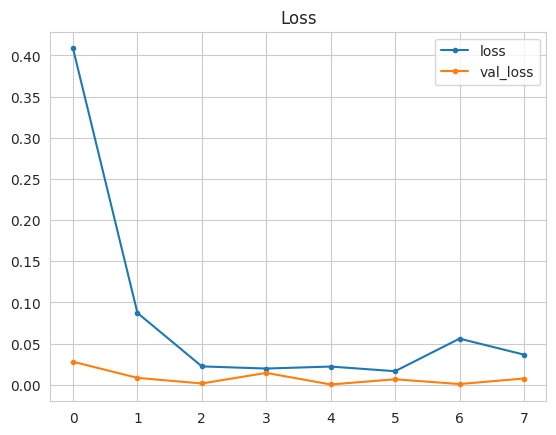

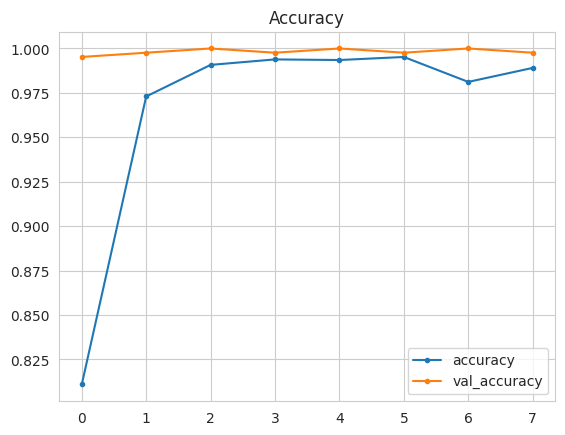

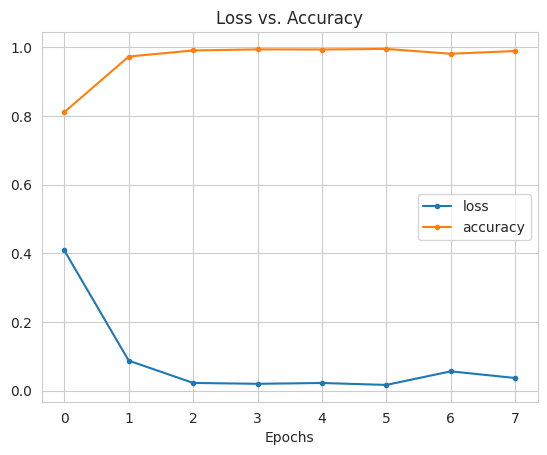

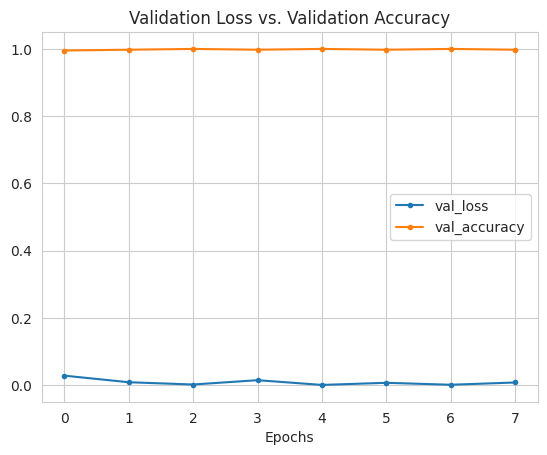

In [26]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")

# Plotting Loss
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Plotting Accuracy
print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Additional Chart 1: Loss vs. Accuracy
losses[['loss', 'accuracy']].plot(style='.-')
plt.title("Loss vs. Accuracy")
plt.xlabel("Epochs")
plt.savefig(f'{file_path}/loss_vs_accuracy.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Additional Chart 2: Validation Loss vs. Validation Accuracy
print("\n")
losses[['val_loss', 'val_accuracy']].plot(style='.-')
plt.title("Validation Loss vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.savefig(f'{file_path}/val_loss_vs_val_accuracy.png',
            bbox_inches='tight', dpi=150)
plt.show()

**Model evaluation**


Load the saved model

In [27]:
from keras.models import load_model
model = load_model('outputs/4/cherry-leaves-model-h1')

In [28]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 10s 219ms/step - loss: 0.0071 - accuracy: 0.9988


Save evaluation pickle

In [29]:
joblib.dump(value=evaluation,
            filename=f"outputs/4/evaluation.pkl")

['outputs/4/evaluation.pkl']

**Predict on new data**

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


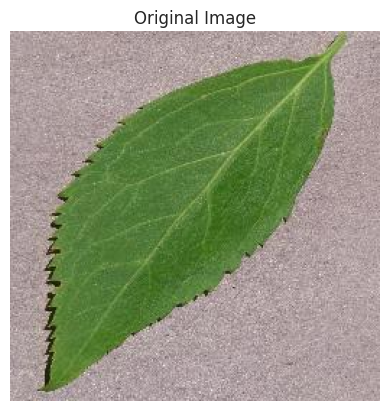

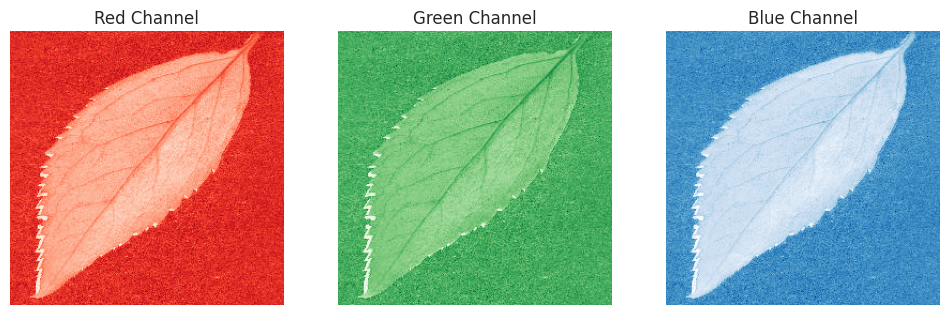

In [30]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # Select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')

# Display loaded image
plt.imshow(pil_image)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Plot the RGB channels separately
r, g, b = pil_image.split()
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(r, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(b, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.show()

Convert image to array and prepare for prediction

In [31]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [32]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999984492767453
healthy


---

## Conclusion 

---

* **Model Performance:** During implementation of this notebook the ML model ran "Fit model for training" once. Accuracy above 97% and reached desired result of 100% accuracy.
* **Future Improvements:** For future improvements the dataset could be exppanded. The ML model can be tested on a more diverse dataset. Also the hyperparameters can be refined. 